## <center>3. Estimación de Parámetros en Modelos Truncados</center>

Cuando trabajamos con datos truncados, **NO podemos usar métodos tradicionales** como la media y la desviación estándar directamente, ya que los valores fuera del rango truncado no están presentes en la muestra. Esto introduce un sesgo en la estimación de parámetros.

### 3.1. Librerias utilizadas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy.optimize as opt
import scipy.stats as stats

### 3.2. Métodos para la Estimación de Parámetros

#### 3.2.1. Metodo de Maxima Verosimilitud (MLE)
Es un método estadístico que encuentra los parámetros que maximizan la probabilidad de observar los datos dados. Se basa en la función de verosimilitud, que mide qué tan probable es obtener los datos observados para diferentes valores de los parámetros del modelo.

Función de estimacion por el método de maxima verosimilitud

In [20]:
def log_likelihood(params, data, a, b):
  mu, sigma = params
  if sigma <= 0:
    return np.inf  # Penalización por valores no válidos

  ll = np.sum(stats.truncnorm.logpdf(
    data, (a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma
  ))
  return -ll  # Se minimiza la función negativa

#### 3.2.2. Método de Momentos (MoM)
El método de momentos es otra opción para estimar los parámetros de una distribución. En este caso, igualamos los momentos teóricos de la distribución truncada con los momentos muestrales y resolvemos para los parámetros desconocidos.

Función de estimacion por el método de momentos

In [ ]:
def moments_equations(params, data, a, b):
  mu, sigma = params
  alpha, beta = (a - mu) / sigma, (b - mu) / sigma
  Z = stats.norm.cdf(beta) - stats.norm.cdf(alpha)
  mean_theoretical = mu + (stats.norm.pdf(alpha) - stats.norm.pdf(beta)) * sigma / Z
  var_theoretical = sigma**2 * (1 + (alpha * stats.norm.pdf(alpha) - beta * stats.norm.pdf(beta)) / Z - ((stats.norm.pdf(alpha) - stats.norm.pdf(beta)) / Z) ** 2)
  return [np.mean(data) - mean_theoretical, np.var(data) - var_theoretical]

#### 3.2.3. Método de Inferencia Bayesiana
El método de Inferencia Bayesiana permite estimar los parámetros incorporando una distribución previa sobre ellos y actualizándola con los datos observados.

Función de estimacion por el método de Inferencia Bayesiana

In [30]:
def bayesian_inference(data, a, b):
  # Asegurar que no se modifiquen los datos originales
  data_copy = np.copy(data)

  with pm.Model() as model:
    mu = pm.Normal("mu", mu=5, sigma=2)  # Prior para mu
    sigma = pm.HalfNormal("sigma", sigma=2)  # Prior para sigma

    # Distribución truncada para los datos
    likelihood = pm.TruncatedNormal("likelihood", mu=mu, sigma=sigma, lower=a, upper=b, observed=data_copy)

    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

  mu_est_bayes = trace.posterior["mu"].mean().item()
  sigma_est_bayes = trace.posterior["sigma"].mean().item()

  return mu_est_bayes, sigma_est_bayes, trace

In [ ]:
usar_metodo_bayesiano = False

### 3.3. Comparación Metodos para la estimacion de parámetros

#### 3.3.1. Generar datos simulados de una distribución normal truncada

In [22]:
# Semilla para reproducibilidad
np.random.seed(42)

# límites de truncamiento
a, b = 0, 10

# parámetros reales
mu_real, sigma_real = 5, 1.5

# datos generados
data = stats.truncnorm.rvs(
    (a - mu_real) / sigma_real, (b - mu_real) / sigma_real,
    loc=mu_real, scale=sigma_real, size=1000
)

#### 3.3.2. Estimación por Máxima Verosimilitud

In [23]:
initial_guess = [np.mean(data), np.std(data)]
result = opt.minimize(log_likelihood, initial_guess, args=(data, a, b))
mu_est_mle, sigma_est_mle = result.x

#### 3.3.3. Estimación por el Método de Momentos

In [24]:
mom_result = opt.root(moments_equations, initial_guess, args=(data, a, b))
mu_est_mom, sigma_est_mom = mom_result.x

#### 3.3.4. Estimación por el Método de Inferencia Bayesiana

In [ ]:
if usar_metodo_bayesiano:
  mu_est_bayes, sigma_est_bayes, trace = bayesian_inference(data, a, b)
else:
  print("No se ha realizado inferencia bayesiana")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 718 draw iterations (4_000 + 2_872 draws total) took 443 seconds.


#### 3.3.5. Comparación con los coeficientes verdaderos

In [33]:
print(f"Parámetros reales: mu = {mu_real}, sigma = {sigma_real}")
print(f"Estimaciones MLE: mu = {mu_est_mle:.4f}, sigma = {sigma_est_mle:.4f}")
print(f"Estimaciones MoM: mu = {mu_est_mom:.4f}, sigma = {sigma_est_mom:.4f}")

if usar_metodo_bayesiano:
  print(f"Estimaciones Bayes: mu = {mu_est_bayes:.4f}, sigma = {sigma_est_bayes:.4f}")
else:
  print("Estimaciones Bayes: No calculadas")

Parámetros reales: mu = 5, sigma = 1.5
Estimaciones MLE: mu = 4.9518, sigma = 1.4980
Estimaciones MoM: mu = 4.9518, sigma = 1.4980
Estimaciones Bayes: mu = 4.9524, sigma = 1.5006


#### 3.3.6. Visualización de la distribución

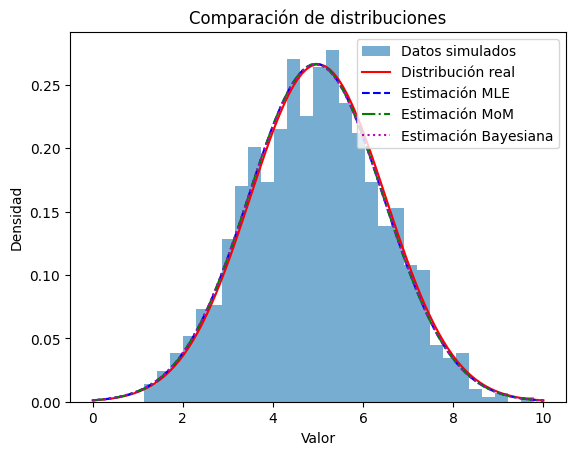

In [34]:
x = np.linspace(a, b, 100)
real_pdf = stats.truncnorm.pdf(x, (a - mu_real) / sigma_real, (b - mu_real) / sigma_real, loc=mu_real, scale=sigma_real)
est_pdf_mle = stats.truncnorm.pdf(x, (a - mu_est_mle) / sigma_est_mle, (b - mu_est_mle) / sigma_est_mle, loc=mu_est_mle, scale=sigma_est_mle)
est_pdf_mom = stats.truncnorm.pdf(x, (a - mu_est_mom) / sigma_est_mom, (b - mu_est_mom) / sigma_est_mom, loc=mu_est_mom, scale=sigma_est_mom)

if usar_metodo_bayesiano:
  est_pdf_bayes = stats.truncnorm.pdf(x, (a - mu_est_bayes) / sigma_est_bayes, (b - mu_est_bayes) / sigma_est_bayes, loc=mu_est_bayes, scale=sigma_est_bayes)

plt.hist(data, bins=30, density=True, alpha=0.6, label="Datos simulados")
plt.plot(x, real_pdf, 'r-', label="Distribución real")
plt.plot(x, est_pdf_mle, 'b--', label="Estimación MLE")
plt.plot(x, est_pdf_mom, 'g-.', label="Estimación MoM")

if usar_metodo_bayesiano:
  plt.plot(x, est_pdf_bayes, 'm:', label="Estimación Bayesiana")

plt.legend()
plt.xlabel("Valor")
plt.ylabel("Densidad")
plt.title("Comparación de distribuciones")
plt.show()

### 3.4. Conclusion

*Resultados*

**Parámetros reales:** `mu = 5, sigma = 1.5`

**Estimaciones MLE:** `mu = 4.9518, sigma = 1.4980`

**Estimaciones MoM:** `mu = 4.9518, sigma = 1.4980`

**Estimaciones Bayes:** `mu = 4.9524, sigma = 1.5006`

En este caso, los métodos de **Máxima Verosimilitud (MLE)** y **Método de Momentos (MoM)** arrojaron exactamente los mismos valores para los parámetros estimados, mu (μ) y sigma (𝜎), lo que indica que ambos métodos fueron igualmente efectivos en la recuperación de los valores reales.

Por otro lado, la **Inferencia Bayesiana** también obtuvo estimaciones muy cercanas a los valores verdaderos, con una ligera mejora en la precisión. Sin embargo, la diferencia con respecto a MLE y MoM no fue significativa en este escenario.

En términos generales, *MLE es el método más utilizado debido a su eficiencia y buenas propiedades estadísticas*. No obstante, la Inferencia Bayesiana es una alternativa poderosa cuando se desea incorporar información previa o cuando la incertidumbre en la estimación es un factor clave, aunque suele requerir más tiempo de cómputo.